In [3]:
import mlrose_hiive as mlrose

import pandas as pd
import random
from tqdm import tqdm
import time
import glob
import ast
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_colwidth', 1000)

RANDOM_SEED = 42
NUM_TUNING_REPEATS = 10
NUM_EVAL_REPEATS = 10
random.seed(RANDOM_SEED)

In [4]:
def find_best_parameters(problem_name):
    # Get the list of files
    files = glob.glob(f'{problem_name}_parameter_tuning_*.csv')
    
    # Find the file with the highest number
    latest_file = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    
    # Load the latest file into a pandas dataframe
    df = pd.read_csv(latest_file)
    
    # Group by the specified columns and calculate the mean of the fitness column
    grouped = df.groupby(['alg_name', 'ts_length', 'params']).fitness.mean().reset_index()
    
    # Find the params with the highest mean fitness score for each alg_name and ts_length
    return grouped.loc[grouped.groupby(['alg_name', 'ts_length']).fitness.idxmax()].reset_index(drop=True)



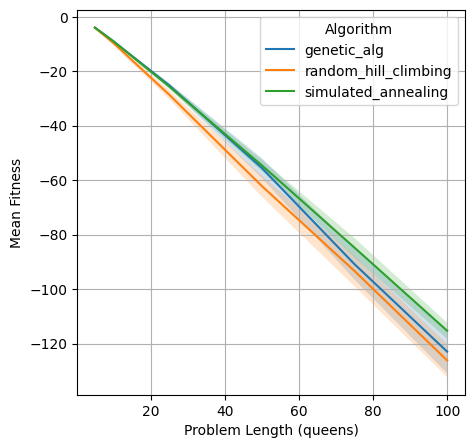

In [14]:
files = glob.glob('combined_evaluation_*.csv')
latest_file = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

output_df = pd.read_csv(latest_file)
grouped_df = output_df.groupby(['problem_name', 'alg_name', 'ts_length'], as_index=False).agg(
    mean_fitness=('fitness', 'mean'),
    std_fitness=('fitness', 'std'),
    mean_duration=('duration', 'mean'),
    std_duration=('duration', 'std')
)

def plot_fitness_by_problem(df):
    problems = df['problem_name'].unique()
    for problem in problems:
        problem_df = df[df['problem_name'] == problem]
        plt.figure(figsize=(5,5))
        for alg in problem_df['alg_name'].unique():
            alg_df = problem_df[problem_df['alg_name'] == alg]
            plt.plot(alg_df['ts_length'], alg_df['mean_fitness'],  label=alg)
            plt.fill_between(alg_df['ts_length'], 
                             alg_df['mean_fitness'] - alg_df['std_fitness'], 
                             alg_df['mean_fitness'] + alg_df['std_fitness'], 
                             alpha=0.2)
        plt.xlabel(f'Problem Length ({problem})')
        plt.ylabel('Mean Fitness')
        plt.legend(title='Algorithm')
        plt.grid(True)
        plt.show()

plot_fitness_by_problem(grouped_df)

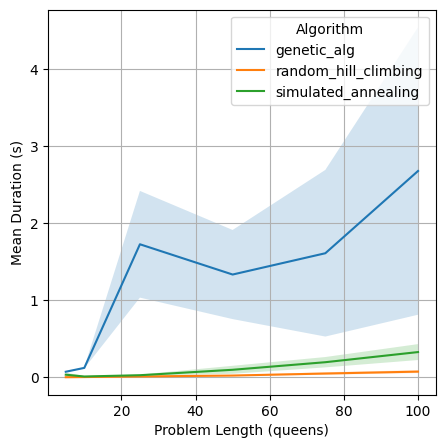

In [8]:
def plot_duration_by_problem(df):
    problems = df['problem_name'].unique()
    for problem in problems:
        problem_df = df[df['problem_name'] == problem]
        plt.figure(figsize=(5,5))
        for alg in problem_df['alg_name'].unique():
            alg_df = problem_df[problem_df['alg_name'] == alg]
            plt.plot(alg_df['ts_length'], alg_df['mean_duration'], label=alg)
            plt.fill_between(alg_df['ts_length'], 
                             alg_df['mean_duration'] - alg_df['std_duration'], 
                             alg_df['mean_duration'] + alg_df['std_duration'], 
                             alpha=0.2)
        plt.xlabel(f'Problem Length ({problem})')
        plt.ylabel('Mean Duration (s)')
        plt.legend(title='Algorithm')
        plt.grid(True)
        plt.show()

plot_duration_by_problem(grouped_df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


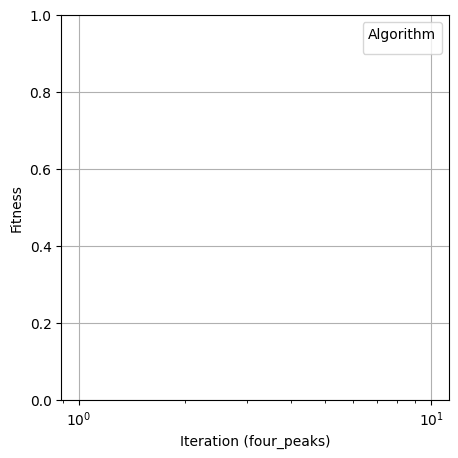

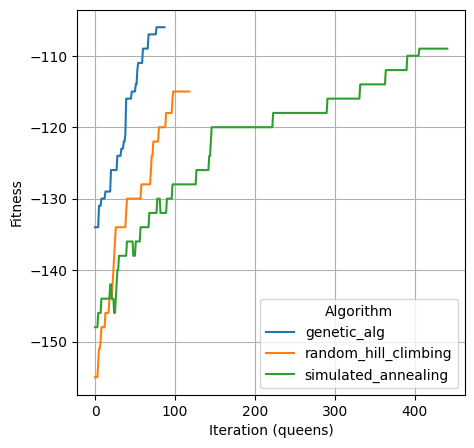

In [11]:
def plot_fitness_by_iteration(df):
    max_fitness_df = df.loc[df.groupby(['problem_name', 'alg_name', 'ts_length'])['fitness'].idxmax()]

    for problem_name in {"queens", "four_peaks"}:
        ts_length = 100 if problem_name == "queens" else 500
        single_length_df = max_fitness_df.loc[(max_fitness_df["ts_length"]==ts_length) & (max_fitness_df["problem_name"]==problem_name)]
        plt.figure(figsize=(5,5))
        for _, row in single_length_df.iterrows():
            curve = np.array(ast.literal_eval(row["curve"]))
            plt.plot(curve[:,0], label=row["alg_name"])
        if problem_name=="four_peaks":
            plt.xscale('log')
        plt.xlabel(f'Iteration ({problem_name})')
        plt.ylabel('Fitness')
        plt.legend(title='Algorithm')
        plt.grid(True)
        plt.show()

plot_fitness_by_iteration(output_df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


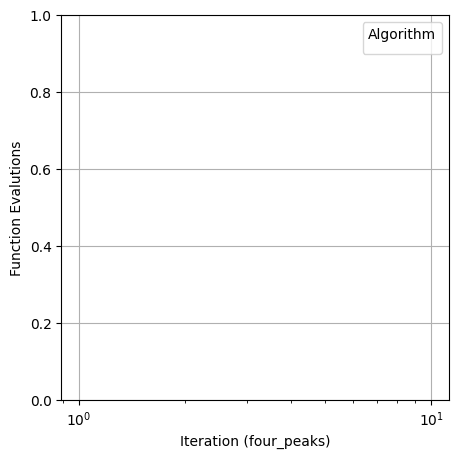

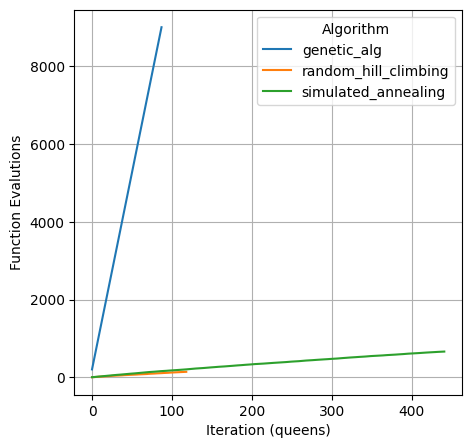

In [12]:
def plot_feval_by_iteration(df):
    max_fitness_df = df.loc[df.groupby(['problem_name', 'alg_name', 'ts_length'])['fitness'].idxmax()]

    for problem_name in {"queens", "four_peaks"}:
        ts_length = 100 if problem_name == "queens" else 500
        single_length_df = max_fitness_df.loc[(max_fitness_df["ts_length"]==ts_length) & (max_fitness_df["problem_name"]==problem_name)]
        plt.figure(figsize=(5,5))
        for _, row in single_length_df.iterrows():
            curve = np.array(ast.literal_eval(row["curve"]))
            plt.plot(curve[:,1], label=row["alg_name"])
        

        if problem_name=="four_peaks":
            plt.xscale('log')
        plt.xlabel(f'Iteration ({problem_name})')
        plt.ylabel('Function Evalutions')
        plt.legend(title='Algorithm')
        plt.grid(True)
        plt.show()

plot_feval_by_iteration(output_df)

In [13]:
def get_best_params(df):
    df_filtered = df[(df['problem_name'] == 'queens') & (df['ts_length'] == 100) | 
                    (df['problem_name'] != 'queens') & (df['ts_length'] == 500)]

    # Find the params with the greatest fitness for each problem_name and alg_name
    result = df_filtered.loc[df_filtered.groupby(['problem_name', 'alg_name'])['fitness'].idxmax(), ['problem_name', 'alg_name', 'params']]
    return result


get_best_params(output_df)

,problem_name,alg_name,params
152,queens,genetic_alg,"{'mutation_prob': 0.4, 'pop_size': 100}"
349,queens,random_hill_climbing,{'max_attempts': 20}
526,queens,simulated_annealing,"{'schedule': ArithDecay(init_temp=0.8999999999999999, decay=0.003, min_temp=0.001), 'init_temp': 0.8999999999999999, 'decay': 0.003, 'min_temp': 0.001}"
